In [1]:
print("Hello World")

Hello World


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import Counter
import plotly.express as px
from sklearn.cluster import DBSCAN

## Loading Dataset

In [3]:

# Try reading the CSV file with a different encoding
try:
    store = pd.read_csv("Sample-Superstore.csv", encoding='latin-1')
except UnicodeDecodeError:
    print("Error: Unable to read the file with 'latin-1' encoding.")
    try:
        store = pd.read_csv("Sample-Superstore.csv", encoding='utf-16')
    except UnicodeDecodeError:
        print("Error: Unable to read the file with 'utf-16' encoding.")

## Renaming features

In [4]:

## renaming of the columns to get rid of the space in between column names 
store.rename(columns={"Row ID":"RowID","Order ID": "OrderID", "Order Date": "OrderDate", "Ship Date": "ShipDate", "Ship Mode": "ShipMode", "Customer ID": "CustomerID", "Customer Name": "CustomerName", "Postal Code": "PostalCode", "Product ID": "ProductID","Sub-Category":"SubCategory", "Product Name": "ProductName"}, inplace=True)


In [5]:
#We need to fix OrderDate and ship date to be YYYY/MM/DD (can be ordered easily even when seen as a string). 
store[['OrderDate','ShipDate']] = store[['OrderDate','ShipDate']].apply(pd.to_datetime)

## Creation of new Dataframe for RFM Analysis

In [6]:
"""""
Creating Dataframe for different Parameters.

The paramaters includes:
                        Monetary (amount of money spent)
                        Frequency (how frequently the customer bought something)
                        Recency (how many days has passed from last date to their last purchase)

"""

'""\nCreating Dataframe for different Parameters.\n\nThe paramaters includes:\n                        Monetary (amount of money spent)\n                        Frequency (how frequently the customer bought something)\n                        Recency (how many days has passed from last date to their last purchase)\n\n'

In [7]:

store_monetary = store.groupby('CustomerID', as_index=False)['Sales'].sum()
##renaming sales column to Amount
store_monetary.rename(columns={"Sales":"Amount"},inplace=True)
store_monetary.head()

,CustomerID,Amount
0,AA-10315,5563.560
1,AA-10375,1056.390
2,AA-10480,1790.512
3,AA-10645,5086.935
4,AB-10015,886.156


In [8]:
store_monetary.head()

,CustomerID,Amount
0,AA-10315,5563.560
1,AA-10375,1056.390
2,AA-10480,1790.512
3,AA-10645,5086.935
4,AB-10015,886.156


In [9]:
store_frequency = store.groupby('CustomerID', as_index=False)['OrderID'].count()
store_frequency

,CustomerID,OrderID
0,AA-10315,11
1,AA-10375,15
2,AA-10480,12
3,AA-10645,18
4,AB-10015,6
...,...,...
788,XP-21865,28
789,YC-21895,8
790,YS-21880,12
791,ZC-21910,31


In [10]:
store_recency = store.groupby('CustomerID', as_index=False)['Sales'].sum()
store_recency.head()

,CustomerID,Sales
0,AA-10315,5563.560
1,AA-10375,1056.390
2,AA-10480,1790.512
3,AA-10645,5086.935
4,AB-10015,886.156


In [11]:

# Find the last order date in the dataset
reference_date = store['OrderDate'].max()

# Calculate the Recency for each customer
store_recency = store.groupby('CustomerID')['OrderDate'].max().reset_index()
store_recency['Recency'] = (reference_date - store_recency['OrderDate']).dt.days

# Display the first few rows of the resulting DataFrame

store_recency.head()

,CustomerID,OrderDate,Recency
0,AA-10315,2017-06-29,184
1,AA-10375,2017-12-11,19
2,AA-10480,2017-04-15,259
3,AA-10645,2017-11-05,55
4,AB-10015,2016-11-10,415


In [12]:

# Rename columns in store_frequency to match 'CustomerID' for merging
store_frequency = store.groupby('CustomerID')['OrderID'].count().reset_index(name='Frequency')

# Merge the dataframes
parameters = pd.merge(store_monetary, store_frequency, on='CustomerID')
parameters = pd.merge(parameters, store_recency[['CustomerID', 'Recency']], on='CustomerID')

# Display the first few rows of the resulting DataFrame
parameters.head()

,CustomerID,Amount,Frequency,Recency
0,AA-10315,5563.560,11,184
1,AA-10375,1056.390,15,19
2,AA-10480,1790.512,12,259
3,AA-10645,5086.935,18,55
4,AB-10015,886.156,6,415


In [13]:
parameters.head()

,CustomerID,Amount,Frequency,Recency
0,AA-10315,5563.560,11,184
1,AA-10375,1056.390,15,19
2,AA-10480,1790.512,12,259
3,AA-10645,5086.935,18,55
4,AB-10015,886.156,6,415


## Visualization of Outliers

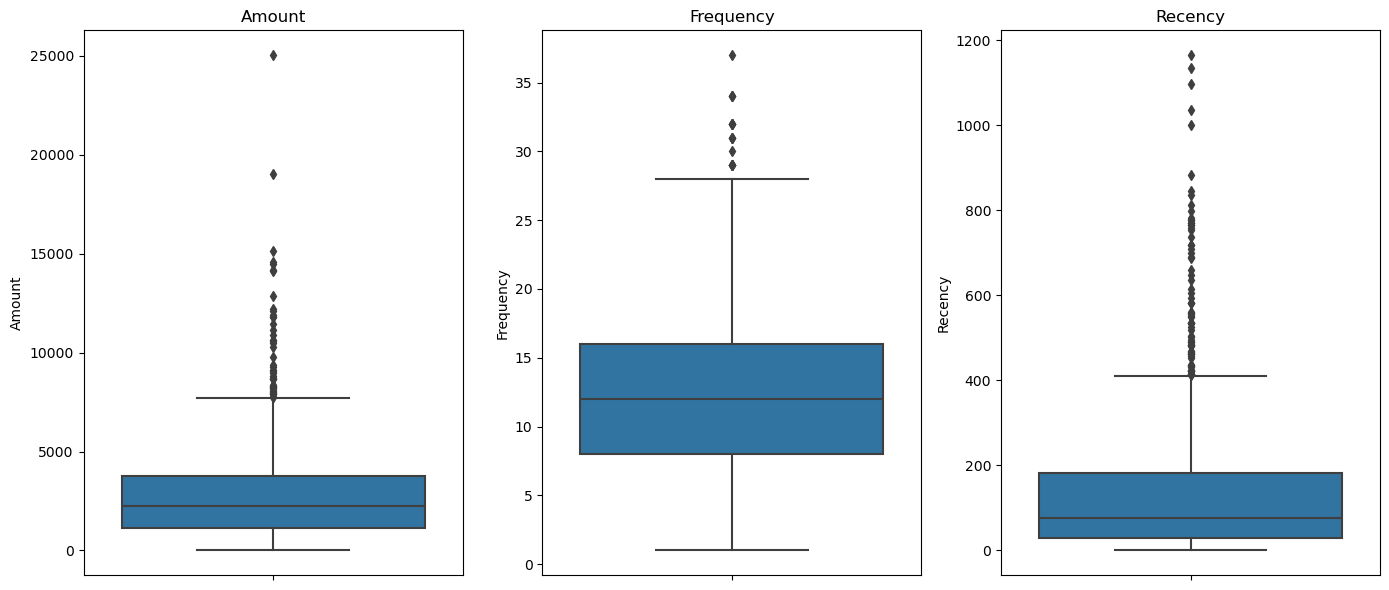

In [14]:


# Create boxplots for Amount, Frequency, and Recency
plt.figure(figsize=(14, 6))

# Amount boxplot
plt.subplot(1, 3, 1)
sns.boxplot(y=parameters['Amount'])
plt.title('Amount')

# Frequency boxplot
plt.subplot(1, 3, 2)
sns.boxplot(y=parameters['Frequency'])
plt.title('Frequency')

# Recency boxplot
plt.subplot(1, 3, 3)
sns.boxplot(y=parameters['Recency'])
plt.title('Recency')

plt.tight_layout()
plt.show()


## Outliers Identification and Removal 

In [15]:
# Function to calculate IQR and filter out outliers
#def remove_outliers_iqr(df, column):
    #Q1 = df[column].quantile(0.25)
    #Q3 = df[column].quantile(0.75)
    #IQR = Q3 - Q1
    #lower_bound = Q1 - 1.5 * IQR
    #upper_bound = Q3 + 1.5 * IQR
    #return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply the function to each column
#parameters_cleaned = parameters.copy()
#for column in ['Amount', 'Frequency', 'Recency']:
    #parameters_cleaned = remove_outliers_iqr(parameters_cleaned, column)




##Alternatively


# Function to calculate IQR and filter out outliers
def remove_outliers_iqr(parameters, column):
    Q1 = parameters[column].quantile(0.25)
    Q3 = parameters[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return parameters[(parameters[column] >= lower_bound) & (parameters[column] <= upper_bound)]

# Apply the function to each column
parameters_cleaned = parameters.copy()
for column in ['Amount', 'Frequency', 'Recency']:
    parameters_cleaned = remove_outliers_iqr(parameters_cleaned, column)

parameters_cleansed=parameters_cleaned.reset_index(drop=True)


In [16]:
parameters_cleansed

,CustomerID,Amount,Frequency,Recency
0,AA-10315,5563.560,11,184
1,AA-10375,1056.390,15,19
2,AA-10480,1790.512,12,259
3,AA-10645,5086.935,18,55
4,AB-10015,886.156,6,415
...,...,...,...,...
658,VS-21820,1055.981,8,221
659,VW-21775,6134.038,18,28
660,YC-21895,5454.350,8,4
661,YS-21880,6720.444,12,9


## Feature Scaling

In [17]:
"""
Using Standardisation Scaling
"""

'\nUsing Standardisation Scaling\n'

In [76]:
# Rescaling the attributes
parameters_clean = parameters_cleansed[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
parameters_scaled = scaler.fit_transform(parameters_clean)
parameters_scaled.shape

parameters_scaled = pd.DataFrame(parameters_scaled)
parameters_scaled.columns = ['Amount', 'Frequency', 'Recency']
parameters_scaled.head()

,Amount,Frequency,Recency
0,1.841594,-0.231602,0.826249
1,-0.851013,0.535200,-0.811889
2,-0.412445,-0.039901,1.570857
3,1.556856,1.110301,-0.454477
4,-0.952712,-1.190104,3.119642


## K-Means Algorithmn

In [19]:
"""Here 4 is randomly selected as number of clusters"""

'Here 4 is randomly selected as number of clusters'

In [20]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
# Fit K-Means clustering
kmeans.fit(parameters_scaled)


c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


KMeans(max_iter=50, n_clusters=4)

In [21]:
# Assign cluster labels to each data point
kmeans.labels_
label_list=kmeans.labels_
sorted(Counter(label_list).items())

[(0, 245), (1, 207), (2, 108), (3, 103)]

In [22]:
kmeans.cluster_centers_

array([[-0.68388389, -0.76679827, -0.34538911],
       [ 0.16594255,  0.66300021, -0.41318156],
       [ 1.7354526 ,  0.9576509 , -0.25738541],
       [-0.52647996, -0.51263849,  1.92181106]])

In [23]:
"""Visualizing the cnetroids"""

'Visualizing the cnetroids'

In [1]:

# Update the centroids
centroids = [[0.18357285, 0.66174109, -0.44758085],
             [-0.68467531, -0.76228487, -0.34417787],
             [1.73737329, 0.97772338, -0.24264617],
             [-0.51153368, -0.48063333, 1.88308234]]



In [25]:
"""""Visualizing the Clusters"""

'""Visualizing the Clusters'

In [27]:
kmeans.labels_

array([2, 1, 3, 2, 3, 0, 1, 0, 0, 3, 2, 1, 3, 2, 1, 3, 3, 0, 0, 0, 1, 1,
       0, 2, 0, 1, 1, 0, 2, 3, 0, 2, 2, 2, 0, 0, 0, 2, 1, 0, 0, 0, 2, 2,
       0, 1, 0, 1, 3, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 1, 2, 1, 3, 1, 0, 0,
       0, 3, 1, 0, 3, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 1, 0, 3, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 3, 3, 3, 0, 1, 3, 3, 2, 3, 1, 3, 1, 0,
       1, 0, 2, 0, 2, 1, 1, 0, 1, 1, 0, 0, 0, 3, 0, 3, 3, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 3, 2, 2, 2, 0, 0, 0, 0, 0, 1, 3, 1, 1, 0, 2, 1, 3, 1,
       0, 1, 3, 1, 3, 2, 1, 1, 2, 3, 3, 1, 0, 0, 1, 0, 0, 0, 2, 1, 0, 2,
       0, 1, 0, 2, 1, 1, 1, 1, 0, 1, 0, 2, 1, 3, 0, 0, 1, 1, 3, 2, 1, 1,
       0, 1, 0, 2, 0, 3, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 3, 3, 0,
       1, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 3, 0, 2, 1, 1, 3, 0, 2, 3,
       2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 0, 1, 1, 1, 3, 0, 2, 1, 1, 0, 1,
       2, 0, 0, 2, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 2, 3, 0, 0, 2, 0, 0, 2,
       3, 3, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 3, 3, 2,

## Evaluation of K-Means (Finding the optimal number of clusters)

### Elbow Method

In [28]:
from sklearn import metrics
from scipy.spatial.distance import cdist

In [29]:
"""
Build the clustering model and calculate the distortion and inertia values
"""

'\nBuild the clustering model and calculate the distortion and inertia values\n'

In [30]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
	# Building and fitting the model
	kmeanModel = KMeans(n_clusters=k).fit(parameters_scaled)
	kmeanModel.fit(parameters_scaled)

	distortions.append(sum(np.min(cdist(parameters_scaled, kmeanModel.cluster_centers_,
										'euclidean'), axis=1)) / parameters_scaled.shape[0])
	inertias.append(kmeanModel.inertia_)

	mapping1[k] = sum(np.min(cdist(parameters_scaled, kmeanModel.cluster_centers_,
								'euclidean'), axis=1)) / parameters_scaled.shape[0]
	mapping2[k] = kmeanModel.inertia_


c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can a

In [31]:
"""""Tabulating and Visualizing the Results:
(a) Using the different distortion values
"""

'""Tabulating and Visualizing the Results:\n(a) Using the different distortion values\n'

In [32]:
for key, val in mapping1.items():
	print(f'{key} : {val}')


1 : 1.8685356320193796
2 : 1.4952150027298607
3 : 1.0922074135496898
4 : 0.9408014827800444
5 : 0.8958660974349762
6 : 0.8482088339238788
7 : 0.8128117856980118
8 : 0.7586407617613999
9 : 0.7378273081625889


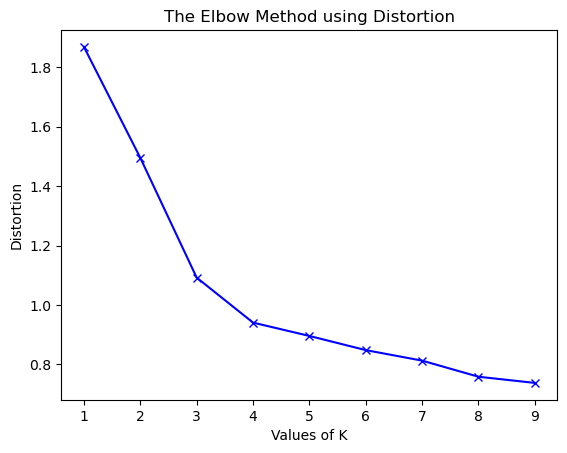

In [33]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()


In [34]:
""""
(b) Using the different inertia values
"""

'"\n(b) Using the different inertia values\n'

In [35]:
for key, val in mapping2.items():
	print(f'{key} : {val}')


1 : 2746.819004524887
2 : 1789.2166418361014
3 : 952.8273543836633
4 : 701.593783228343
5 : 632.7591552899321
6 : 574.595581866813
7 : 517.1799051289017
8 : 461.43667129802196
9 : 430.1020086135918


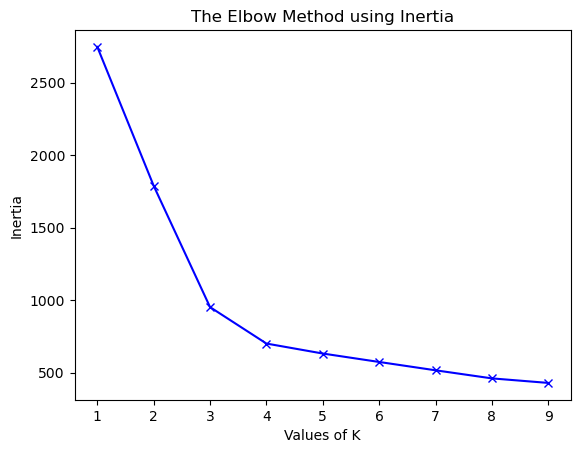

In [36]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()


In [37]:
""""
Clustering data points for different k values
"""

'"\nClustering data points for different k values\n'

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


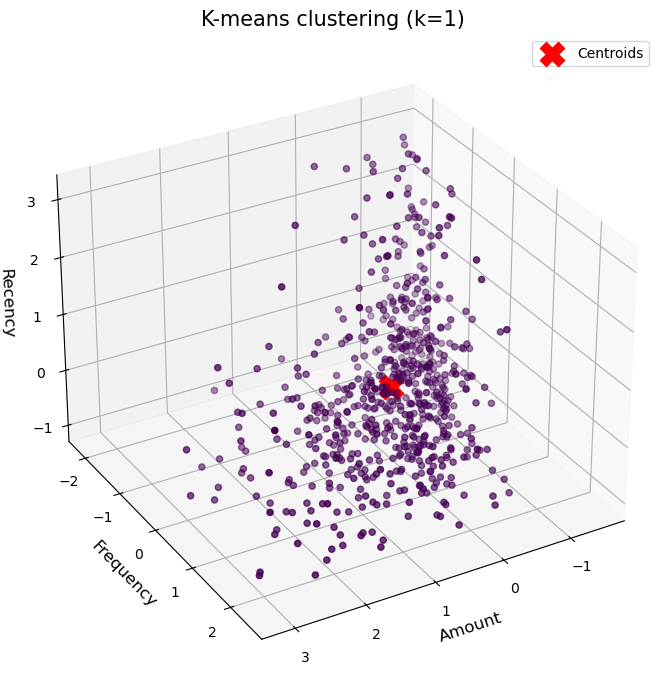

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


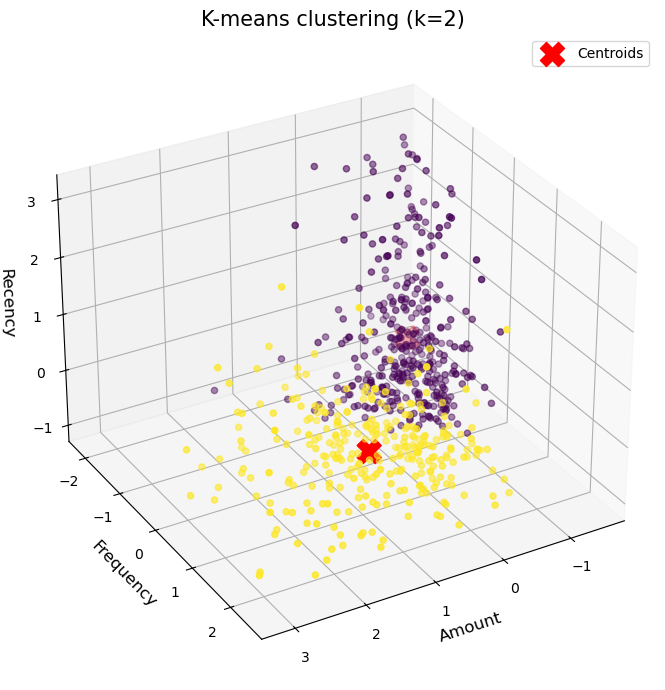

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


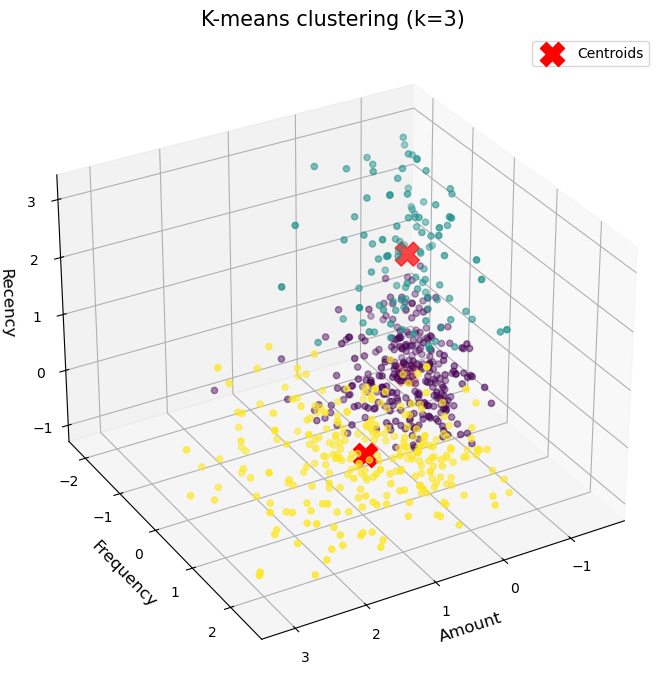

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


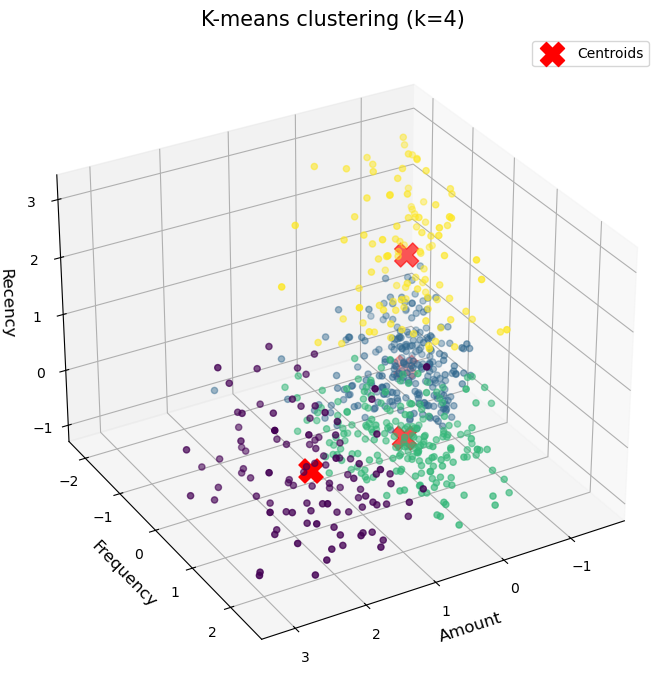

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


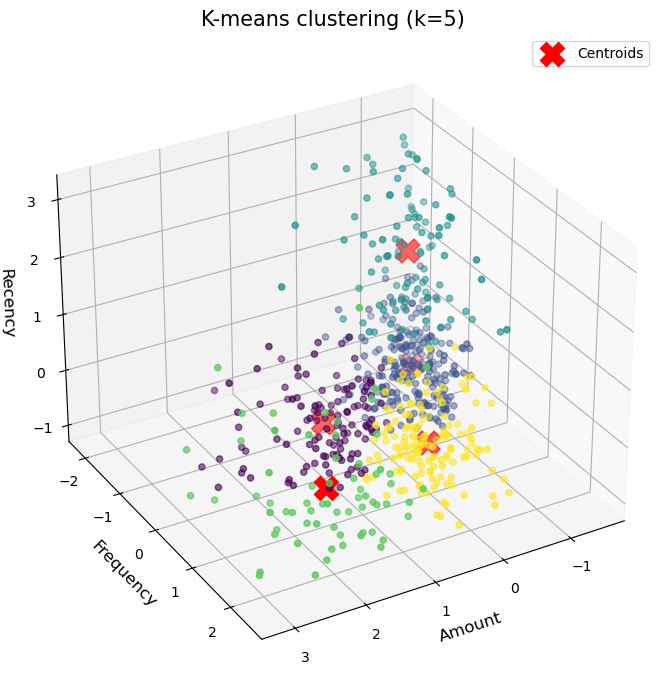

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


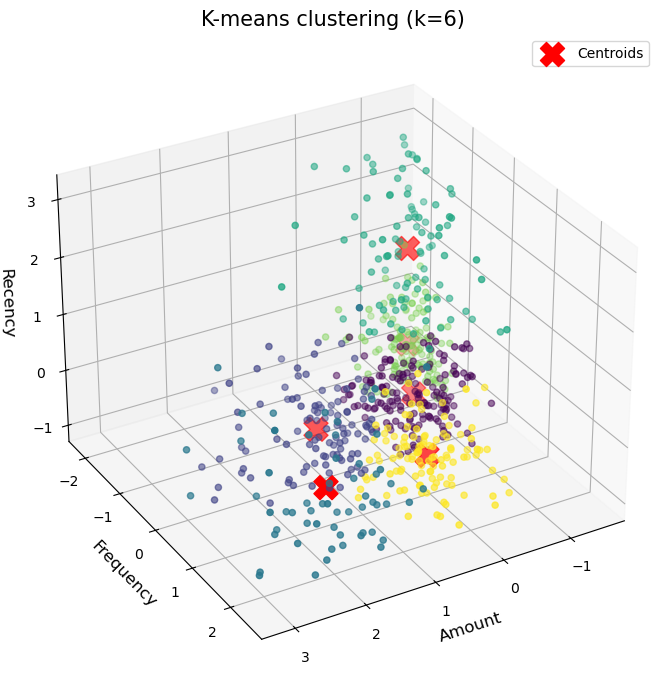

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


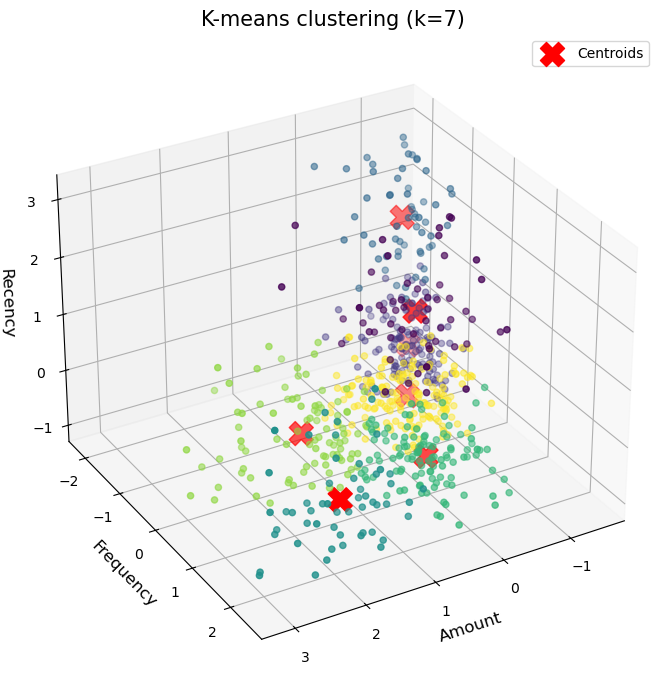

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


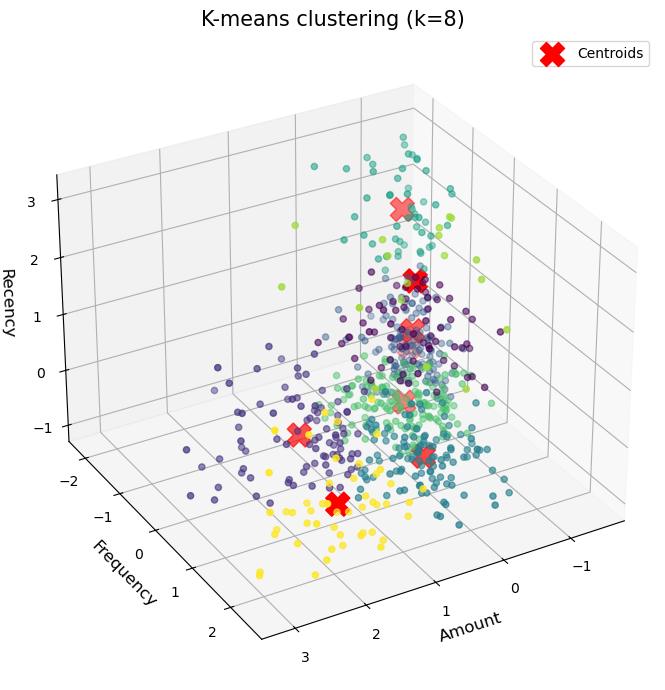

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


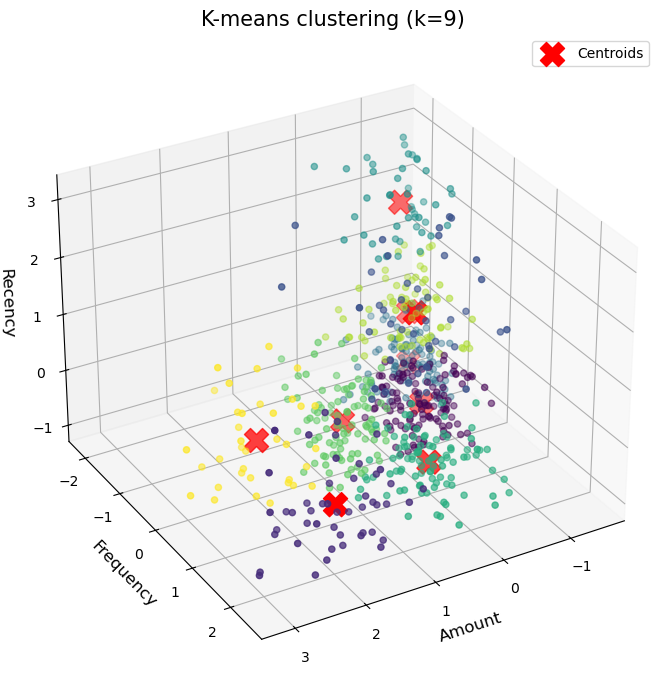

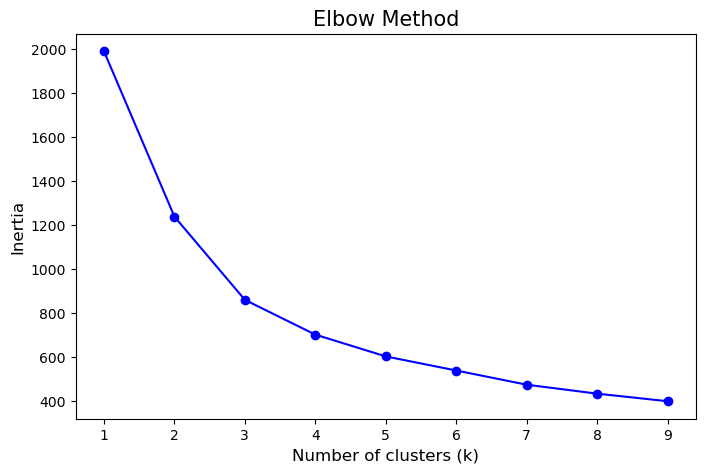

In [38]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

# Create a range of values for k
k_range = range(1, 10)

# Initialize an empty list to store the inertia values for each k
inertia_values = []

# Fit and plot the data for each k value
for k in k_range:
    kmeans = KMeans(n_clusters=k,max_iter=50, init='k-means++', random_state=42)
    y_kmeans = kmeans.fit_predict(parameters_scaled[['Amount', 'Frequency', 'Recency']])
    inertia_values.append(kmeans.inertia_)
    
    # 3D scatter plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(parameters_scaled['Amount'], parameters_scaled['Frequency'], parameters_scaled['Recency'], c=y_kmeans, cmap='viridis')
    
    # Plot centroids
    centers = kmeans.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], s=300, c='red', marker='X', label='Centroids')
    
    # Add labels and title
    ax.set_xlabel('Amount', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_zlabel('Recency', fontsize=12)
    ax.set_title('K-means clustering (k={})'.format(k), fontsize=15)
    ax.legend()
    
    # Adjust view angle
    ax.view_init(elev=30, azim=60)
    
    # Adjust layout to ensure labels are fully visible
    fig.tight_layout()
    
    plt.show()

# Plot the inertia values for each k
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia_values, 'bo-')
plt.title('Elbow Method', fontsize=15)
plt.xlabel('Number of clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.show()


### Silhouette Analysis

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 2, the average silhouette_score is 0.34127785935046806


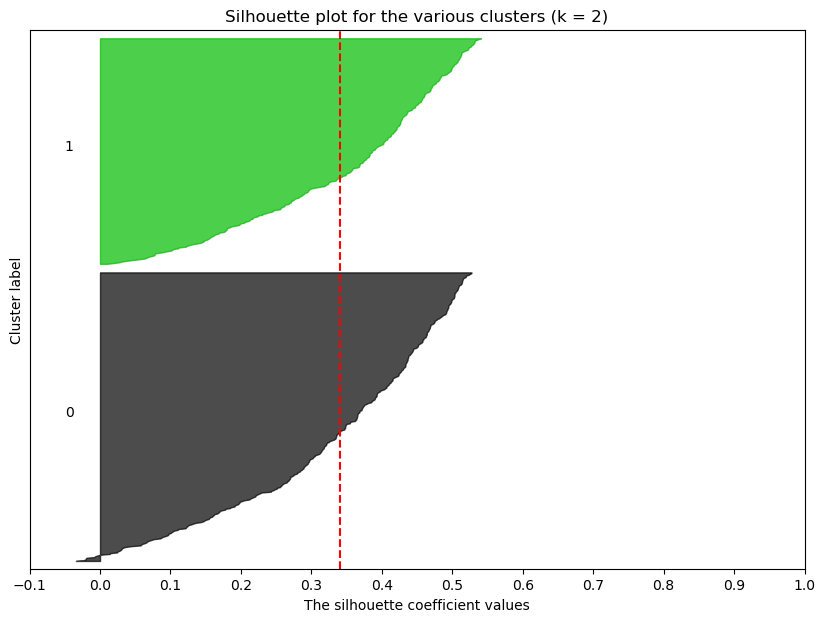

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 3, the average silhouette_score is 0.3639766085154882


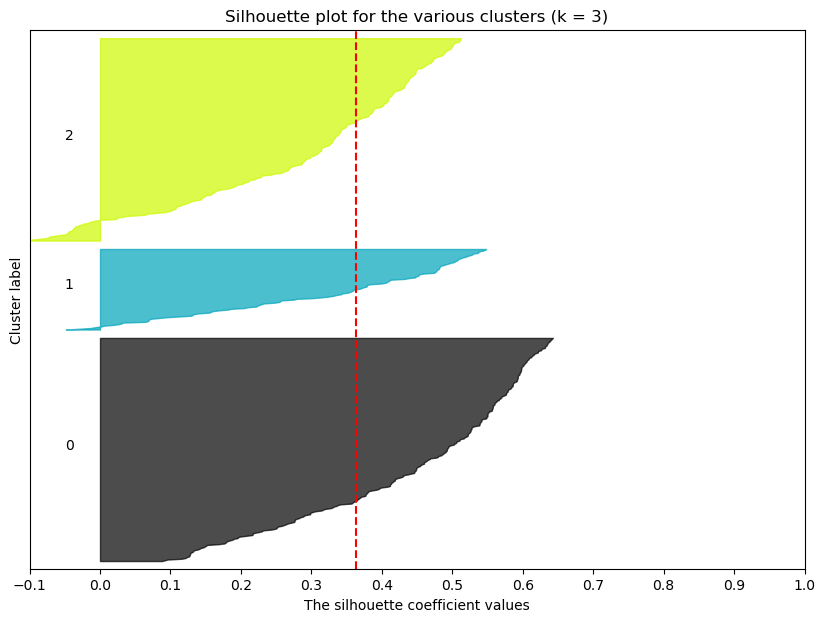

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 4, the average silhouette_score is 0.31991216682124246


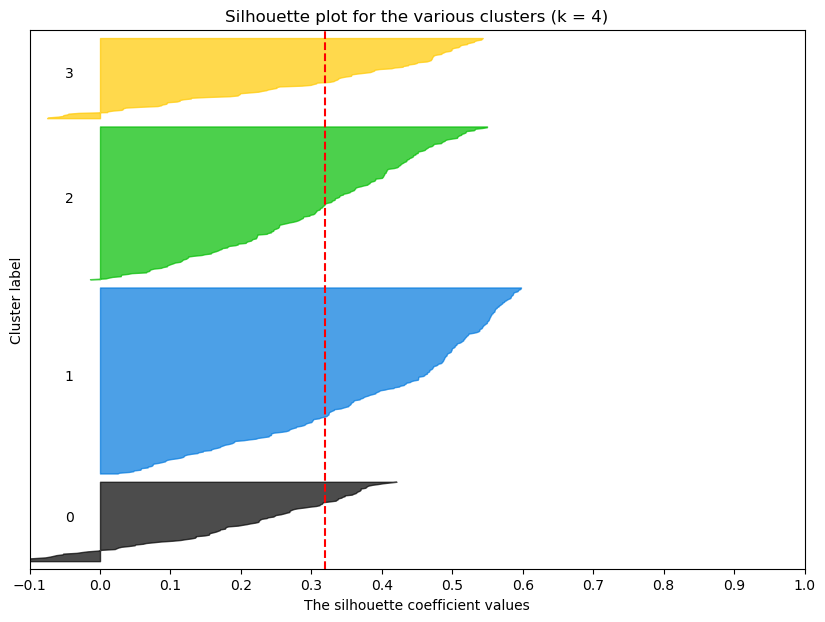

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 5, the average silhouette_score is 0.3358630532418994


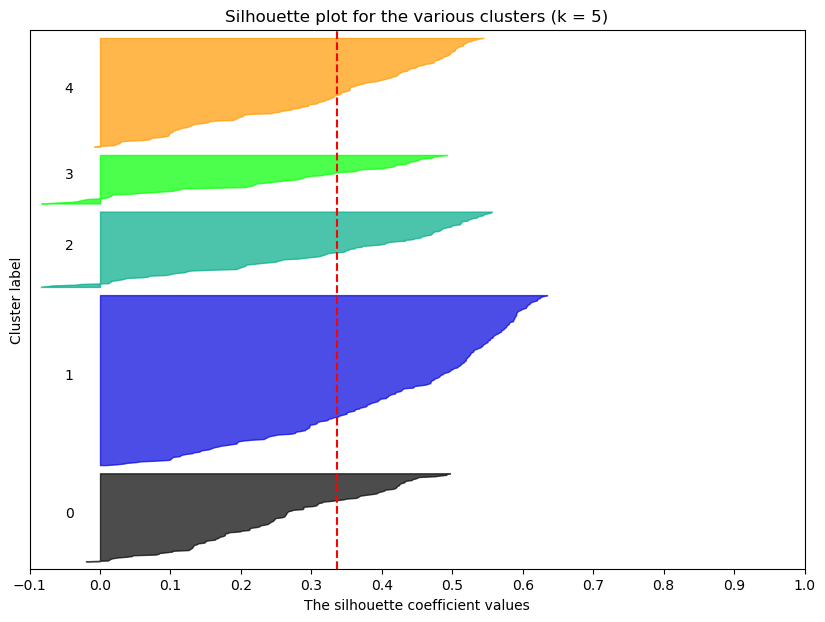

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 6, the average silhouette_score is 0.2783038524949176


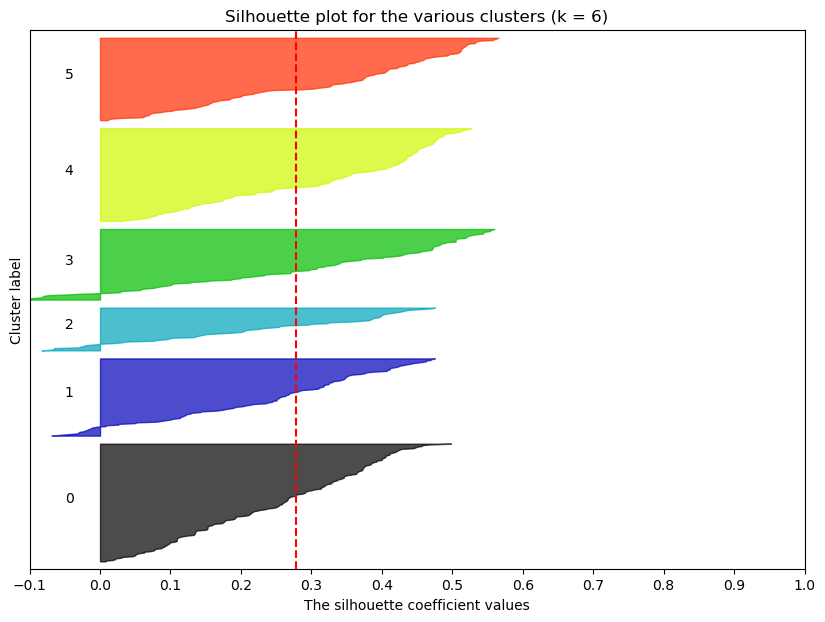

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 7, the average silhouette_score is 0.281142776787198


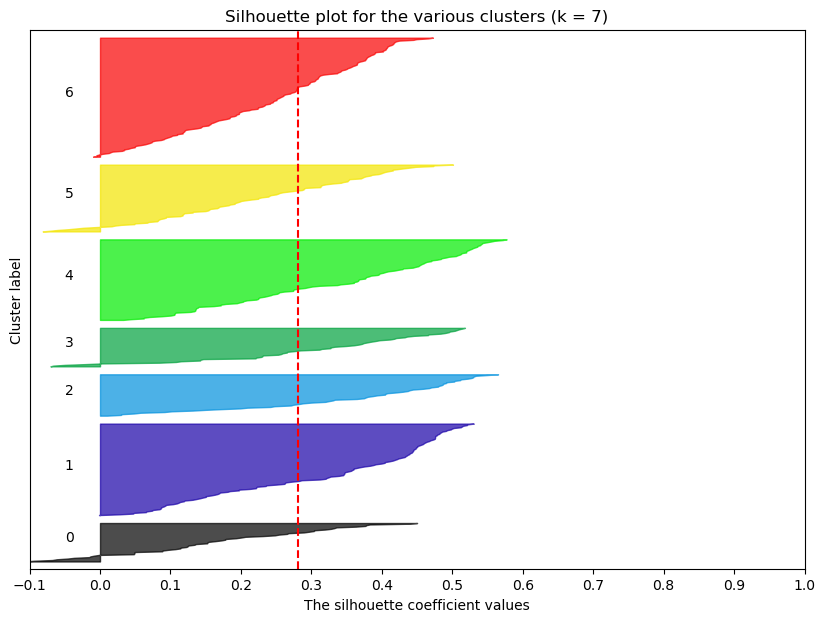

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 8, the average silhouette_score is 0.2888015690884803


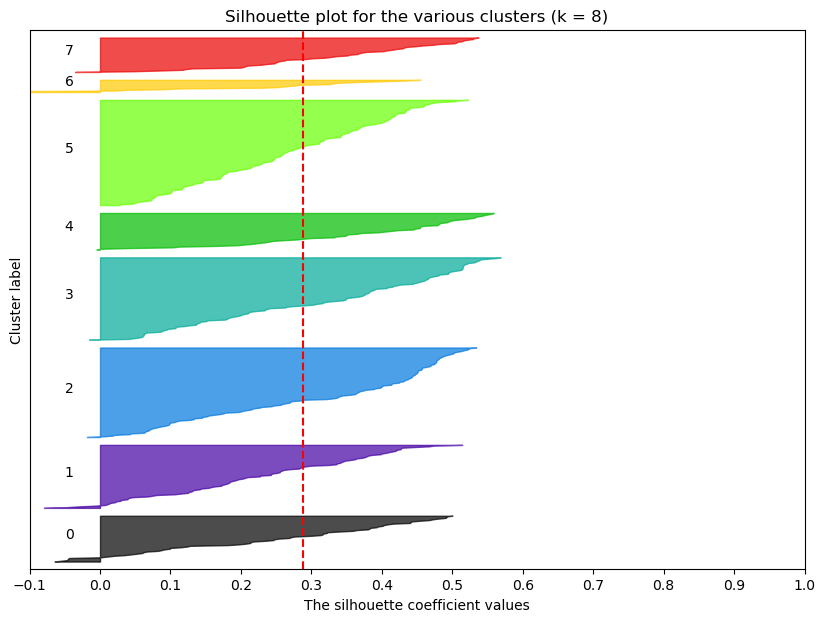

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


For n_clusters = 9, the average silhouette_score is 0.2747432730844653


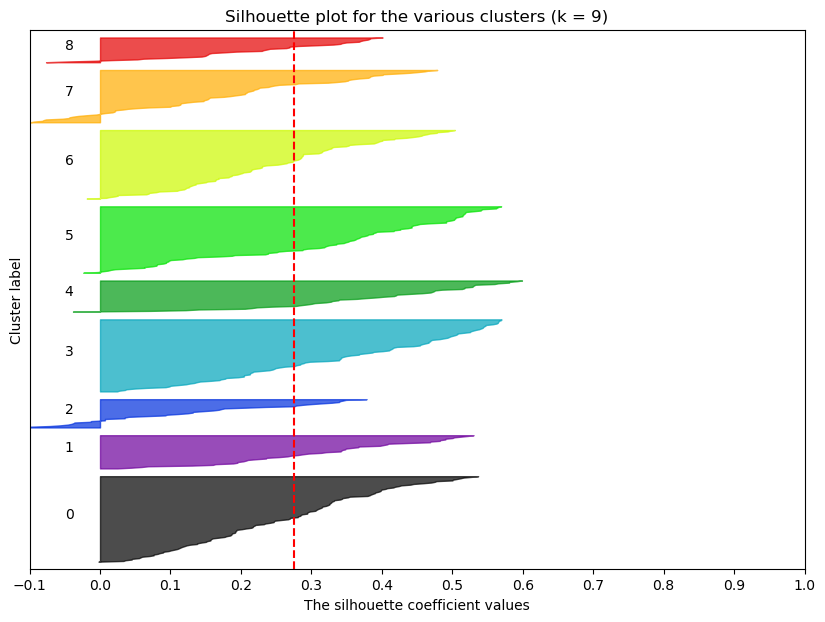

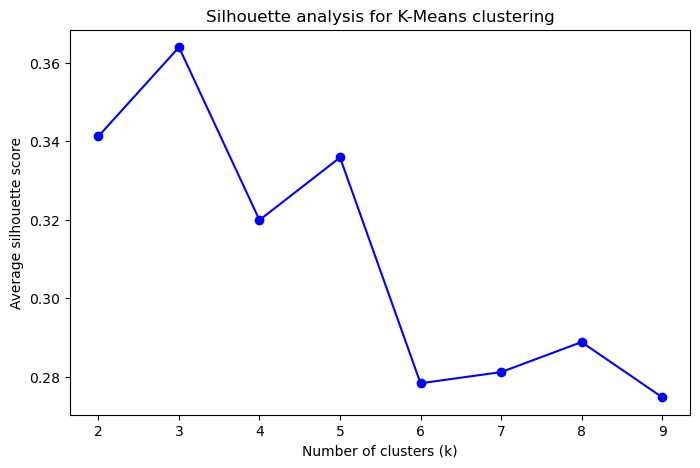

In [39]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np

# Create a range of values for k
k_range = range(2, 10)

# Initialize lists to store the average silhouette scores for each k
silhouette_avg_scores = []

# Fit the data for each k value and calculate silhouette scores
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=50, random_state=42)
    cluster_labels = kmeans.fit_predict(parameters_scaled[['Amount', 'Frequency', 'Recency']])
    
    silhouette_avg = silhouette_score(parameters_scaled[['Amount', 'Frequency', 'Recency']], cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    
    print(f"For n_clusters = {k}, the average silhouette_score is {silhouette_avg}")

    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(parameters_scaled) + (k + 1) * 10])

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(parameters_scaled[['Amount', 'Frequency', 'Recency']], cluster_labels)

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title(f"Silhouette plot for the various clusters (k = {k})")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([i / 10.0 for i in range(-1, 11)])
    plt.show()

# Plot the average silhouette scores for each k
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_avg_scores, 'bo-')
plt.title('Silhouette analysis for K-Means clustering')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average silhouette score')
plt.show()


## Train Model

In [41]:
"""Traininig of the final model with the appropriate value of k.
"""

'Traininig of the final model with the appropriate value of k.\n'

In [42]:
# k-means with appropriate value of k
kmeans = KMeans(n_clusters=3, max_iter=50)
# Fit K-Means clustering
kmeans.fit(parameters_scaled)

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


KMeans(max_iter=50, n_clusters=3)

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


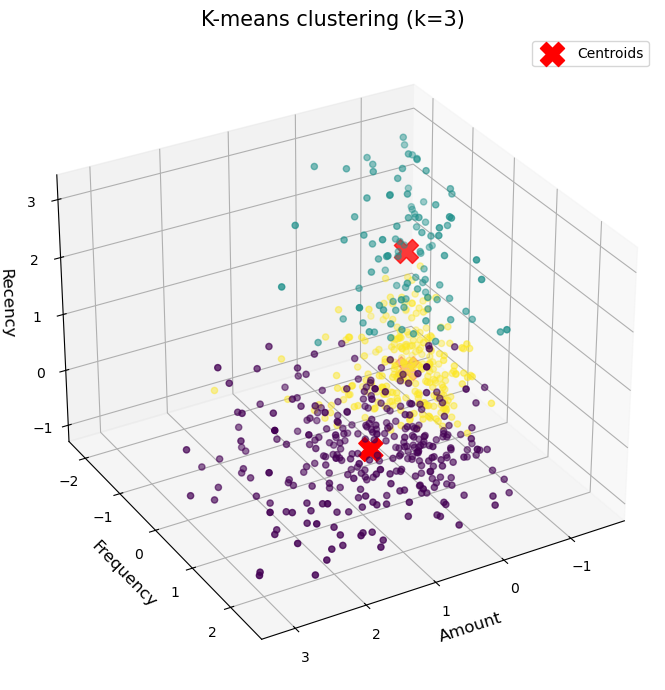

In [43]:
# Fit K-means clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
y_kmeans = kmeans.fit_predict(parameters_scaled)

# 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(parameters_scaled['Amount'], 
                     parameters_scaled['Frequency'], 
                     parameters_scaled['Recency'], 
                     c=y_kmeans, cmap='viridis')

# Plot centroids
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], 
           s=300, c='red', marker='X', label='Centroids')

# Add labels and title
ax.set_xlabel('Amount', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_zlabel('Recency', fontsize=12)
ax.set_title('K-means clustering (k={})'.format(k), fontsize=15)
ax.legend()

# Adjust view angle
ax.view_init(elev=30, azim=60)

# Adjust layout to ensure labels are fully visible
fig.tight_layout()

plt.show()

## 3D visualization

In [75]:

# Fit K-means clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
y_kmeans = kmeans.fit_predict(parameters_scaled)

# Assign the cluster labels to parameters_scaled DataFrame
parameters_scaled['Cluster_Id'] = y_kmeans

# Display the first few rows of parameters_scaled
print(parameters_scaled.head())

# Create a DataFrame for centroids
centers = kmeans.cluster_centers_
centers_df = pd.DataFrame(centers, columns=['Amount', 'Frequency', 'Recency'])
centers_df['Cluster'] = ['Centroid']*len(centers_df)

# Create the 3D scatter plot
fig = px.scatter_3d(parameters_scaled, x='Amount', y='Frequency', z='Recency', 
                    color='Cluster_Id', symbol='Cluster_Id', title=f'K-means Clustering (k={k})',
                    labels={'Amount': 'Amount', 'Frequency': 'Frequency', 'Recency': 'Recency'},
                    opacity=0.7)

# Add centroids to the plot
fig.add_scatter3d(x=centers_df['Amount'], y=centers_df['Frequency'], z=centers_df['Recency'],
                  mode='markers', marker=dict(size=10, color='red', symbol='x'),
                  name='Centroids')

# Update layout to increase figure size and customize legend
fig.update_layout(
    scene=dict(
        xaxis_title='Amount',
        yaxis_title='Frequency',
        zaxis_title='Recency'
    ),
    width=1200,
    height=800,
    legend=dict(
        x=1.125,
        y=1,
        bgcolor='rgba(255, 255, 255, 0.5)',
        bordercolor='Black',
        borderwidth=1
    )
)

# Show the plot
fig.show()


c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



     Amount  Frequency   Recency  Cluster_Id
0  1.841594  -0.231602  0.826249           2
1 -0.851013   0.535200 -0.811889           0
2 -0.412445  -0.039901  1.570857           1
3  1.556856   1.110301 -0.454477           2
4 -0.952712  -1.190104  3.119642           1


In [77]:

# Fit K-means clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
y_kmeans = kmeans.fit_predict(parameters_scaled)

# Assign the cluster labels to parameters_cleansed DataFrame
parameters_cleansed['Cluster_Id'] = y_kmeans

# Display the first few rows of parameters_cleansed
print(parameters_cleansed.head())

# Create a DataFrame for centroids
centers = kmeans.cluster_centers_
centers_df = pd.DataFrame(centers, columns=['Amount', 'Frequency', 'Recency'])
centers_df['Cluster'] = ['Centroid']*len(centers_df)

# Create the 3D scatter plot
fig = px.scatter_3d(parameters_cleansed, x='Amount', y='Frequency', z='Recency', 
                    color='Cluster_Id', symbol='Cluster_Id', title=f'K-means Clustering (k={k})',
                    labels={'Amount': 'Amount', 'Frequency': 'Frequency', 'Recency': 'Recency'},
                    opacity=0.7)

# Add centroids to the plot
#fig.add_scatter3d(x=centers_df['Amount'], y=centers_df['Frequency'], z=centers_df['Recency'],
                 # mode='markers', marker=dict(size=10, color='red', symbol='x'),
                  #name='Centroids')

# Update layout to increase figure size and customize legend
fig.update_layout(
    scene=dict(
        xaxis_title='Amount',
        yaxis_title='Frequency',
        zaxis_title='Recency'
    ),
    width=1200,
    height=800,
    legend=dict(
        x=1.125,
        y=1,
        bgcolor='rgba(255, 255, 255, 0.5)',
        bordercolor='Black',
        borderwidth=1
    )
)

# Show the plot
fig.show()


c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\godwi\Downloads\Anconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



  CustomerID    Amount  Frequency  Recency  Cluster_Id
0   AA-10315  5563.560         11      184           2
1   AA-10375  1056.390         15       19           0
2   AA-10480  1790.512         12      259           1
3   AA-10645  5086.935         18       55           2
4   AB-10015   886.156          6      415           1


In [53]:
cluster_labels = kmeans.labels_
# assign the label
parameters_cleansed['Cluster_Id'] = kmeans.labels_
parameters_cleansed.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,AA-10315,5563.560,11,184,2
1,AA-10375,1056.390,15,19,0
2,AA-10480,1790.512,12,259,1
3,AA-10645,5086.935,18,55,2
4,AB-10015,886.156,6,415,1


## Piechart viz

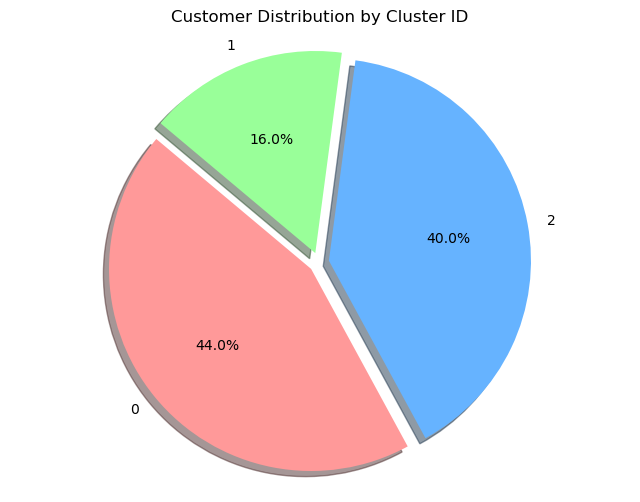

In [78]:
import pandas as pd
import matplotlib.pyplot as plt


# Plotting the pie chart
cluster_counts = parameters_cleansed['Cluster_Id'].value_counts()

# Creating the explode array
explode = [0.05] * len(cluster_counts)  # Adjust the value to create the desired effect

plt.figure(figsize=(8, 6))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'], explode=explode, shadow=True)
plt.title('Customer Distribution by Cluster ID')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()



## Visualizing K-Means Clustering result on Boxplots

<Axes: xlabel='Cluster_Id', ylabel='Amount'>

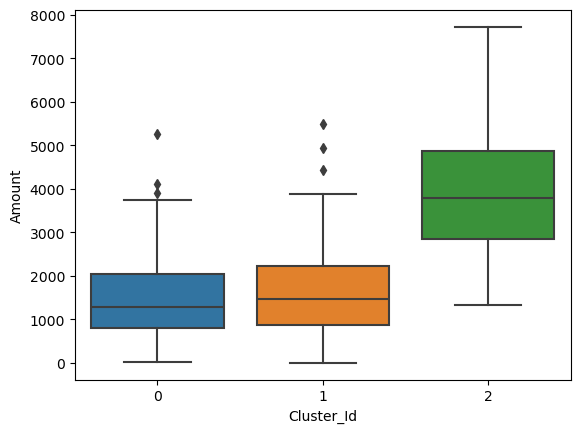

In [55]:
# Box plot to visualize Cluster Id vs Amount
sns.boxplot(x='Cluster_Id', y='Amount', data=parameters_cleansed)


<Axes: xlabel='Cluster_Id', ylabel='Frequency'>

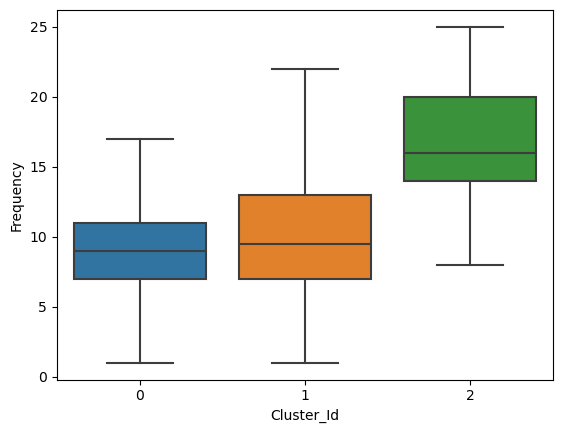

In [56]:
# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=parameters_cleansed)

<Axes: xlabel='Cluster_Id', ylabel='Recency'>

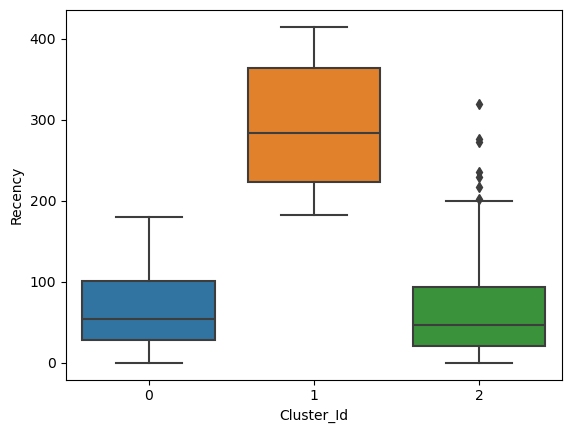

In [57]:
# Box plot to visualize Cluster Id vs Recency
sns.boxplot(x='Cluster_Id', y='Recency', data=parameters_cleansed)

In [58]:
print("Helllo World!")

Helllo World!


## Scaling

In [59]:
# Rescaling the attributes
parameters_clean = parameters_cleansed[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
parameters_scaled = scaler.fit_transform(parameters_clean)
parameters_scaled.shape

parameters_scaled = pd.DataFrame(parameters_scaled)
parameters_scaled.columns = ['Amount', 'Frequency', 'Recency']
parameters_scaled.head()

,Amount,Frequency,Recency
0,1.841594,-0.231602,0.826249
1,-0.851013,0.535200,-0.811889
2,-0.412445,-0.039901,1.570857
3,1.556856,1.110301,-0.454477
4,-0.952712,-1.190104,3.119642


## DBSCAN Algorithmn

### 3D

In [60]:
import pandas as pd
import plotly.express as px
from sklearn.cluster import DBSCAN

# Fit DBSCAN clustering with adjusted parameters
dbscan = DBSCAN(eps=0.5, min_samples=5)
y_dbscan = dbscan.fit_predict(parameters_scaled)

# Assign the cluster labels to parameters_scaled DataFrame
parameters_scaled['Cluster_Id'] = y_dbscan

# Display the first few rows of parameters_scaled
print(parameters_scaled.head())

# Calculate centroids (mean of each cluster)
centroids = parameters_scaled.groupby('Cluster_Id').mean().reset_index()
centroids = centroids[centroids['Cluster_Id'] != -1]  # Exclude noise points

# Create the 3D scatter plot
fig = px.scatter_3d(parameters_scaled, x='Amount', y='Frequency', z='Recency', 
                    color='Cluster_Id', symbol='Cluster_Id', title='DBSCAN Clustering',
                    labels={'Amount': 'Amount', 'Frequency': 'Frequency', 'Recency': 'Recency'},
                    opacity=0.7)

# Add centroids to the plot
fig.add_scatter3d(x=centroids['Amount'], y=centroids['Frequency'], z=centroids['Recency'],
                  mode='markers', marker=dict(size=10, color='red', symbol='x'),
                  name='Centroids')

# Update layout to increase figure size and customize legend
fig.update_layout(
    scene=dict(
        xaxis_title='Amount',
        yaxis_title='Frequency',
        zaxis_title='Recency'
    ),
    width=1200,
    height=800,
    legend=dict(
        x=1.125,
        y=1,
        bgcolor='rgba(255, 255, 255, 0.5)',
        bordercolor='Black',
        borderwidth=1
    )
)

# Show the plot
fig.show()

     Amount  Frequency   Recency  Cluster_Id
0  1.841594  -0.231602  0.826249          -1
1 -0.851013   0.535200 -0.811889           0
2 -0.412445  -0.039901  1.570857           0
3  1.556856   1.110301 -0.454477           0
4 -0.952712  -1.190104  3.119642           1


## Evaluation of DBSCAN Model

In [62]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score, v_measure_score


# Fit DBSCAN clustering with adjusted parameters
dbscan = DBSCAN(eps=0.5, min_samples=5)
cluster_labels = dbscan.fit_predict(parameters_scaled)

# Evaluate clustering
if len(set(cluster_labels)) > 1:  # Silhouette score requires more than 1 cluster
    silhouette_avg = silhouette_score(parameters_scaled, cluster_labels)
    print(f'Silhouette Coefficient: {silhouette_avg}')
else:
    print('Silhouette Coefficient: Not applicable (only one cluster)')

davies_bouldin = davies_bouldin_score(parameters_scaled, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin}')


# Number of clusters and noise points
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)
print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

Silhouette Coefficient: 0.3491366501002172
Davies-Bouldin Index: 1.1474094961456416
Estimated number of clusters: 3
Estimated number of noise points: 72


In [63]:
# assign the label
parameters_cleansed['Cluster_Id'] = y_dbscan
parameters_cleansed.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,AA-10315,5563.560,11,184,-1
1,AA-10375,1056.390,15,19,0
2,AA-10480,1790.512,12,259,0
3,AA-10645,5086.935,18,55,0
4,AB-10015,886.156,6,415,1


## Pie chart viz

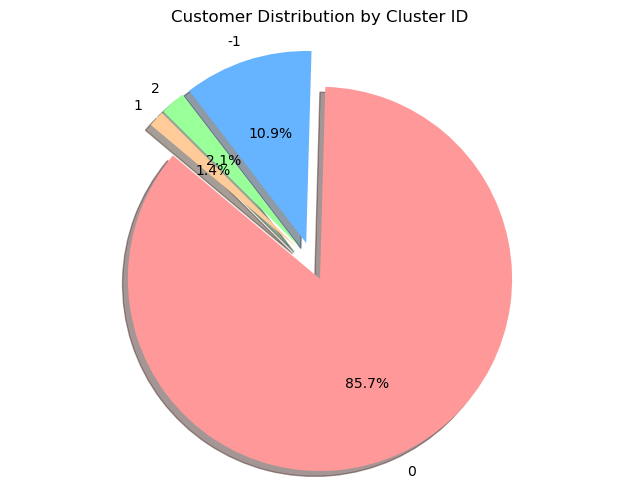

In [72]:
import pandas as pd
import matplotlib.pyplot as plt


# Plotting the pie chart
cluster_counts = parameters_cleansed['Cluster_Id'].value_counts()

# Creating the explode array
explode = [0.1] * len(cluster_counts)  # Adjust the value to create the desired effect

plt.figure(figsize=(8, 6))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'], explode=explode, shadow=True)
plt.title('Customer Distribution by Cluster ID')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()



## Visualizing DBSCAN Clustering Result on Boxplots

<Axes: xlabel='Cluster_Id', ylabel='Amount'>

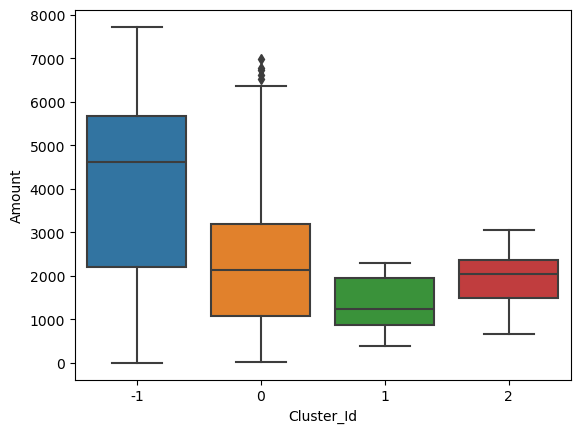

In [65]:
# Box plot to visualize Cluster Id vs Amount
sns.boxplot(x='Cluster_Id', y='Amount', data=parameters_cleansed)


<Axes: xlabel='Cluster_Id', ylabel='Frequency'>

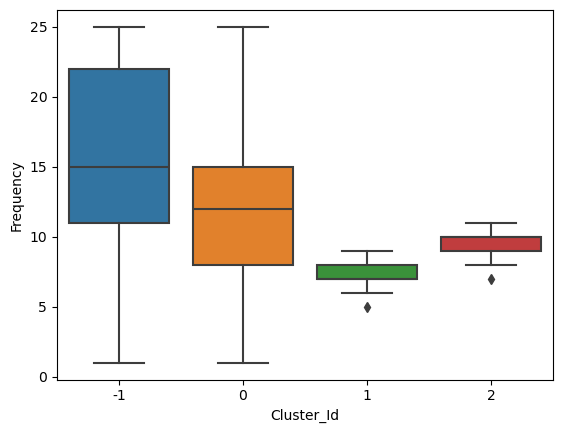

In [66]:
# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=parameters_cleansed)


<Axes: xlabel='Cluster_Id', ylabel='Recency'>

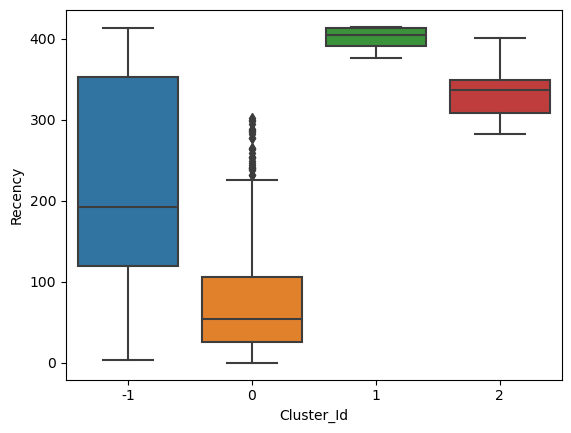

In [67]:
# Box plot to visualize Cluster Id vs Amount
sns.boxplot(x='Cluster_Id', y='Recency', data=parameters_cleansed)


## Extras

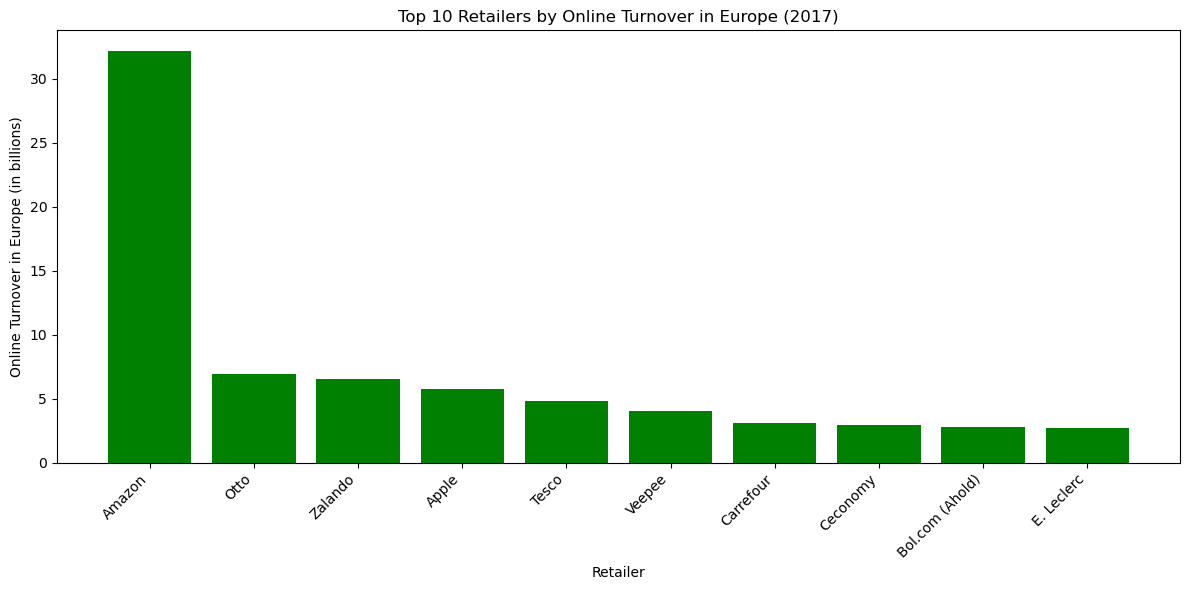

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Data for the dataframe
data = {
    "Rank": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "Retailer": ["Amazon", "Otto", "Zalando", "Apple", "Tesco", "Veepee", "Carrefour", "Ceconomy", "Bol.com (Ahold)", "E. Leclerc"],
    "Online turnover in Europe (in billions)": [32.18, 6.9, 6.5, 5.75, 4.8, 4.0, 3.1, 2.93, 2.8, 2.72],
    "(European) headquarters": ["Luxembourg", "Germany", "Germany", "USA", "The United Kingdom", "France", "France", "Germany", "The Netherlands", "France"]
}

# Creating the dataframe
df = pd.DataFrame(data)

# Creating the bar plot
plt.figure(figsize=(12, 6))
plt.bar(df['Retailer'], df['Online turnover in Europe (in billions)'], color='green')
plt.xlabel('Retailer')
plt.ylabel('Online Turnover in Europe (in billions)')
plt.title('Top 10 Retailers by Online Turnover in Europe (2017)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()


In [69]:
df

,Rank,Retailer,Online turnover in Europe (in billions),(European) headquarters
0,1,Amazon,32.18,Luxembourg
1,2,Otto,6.90,Germany
2,3,Zalando,6.50,Germany
3,4,Apple,5.75,USA
4,5,Tesco,4.80,The United Kingdom
5,6,Veepee,4.00,France
6,7,Carrefour,3.10,France
7,8,Ceconomy,2.93,Germany
8,9,Bol.com (Ahold),2.80,The Netherlands
9,10,E. Leclerc,2.72,France


In [70]:
import pandas as pd

# Creating the DataFrame
data = {
    "Category": [
        "Fashion and Apparel",
        "Consumer Electronics",
        "Furniture and Household Appliance",
        
        
    ],
    "Sales (Billions of Euros)": [
        11.9,
        9.9,
        6.9,
       
     
    ]
}

df = pd.DataFrame(data)
df


,Category,Sales (Billions of Euros)
0,Fashion and Apparel,11.9
1,Consumer Electronics,9.9
2,Furniture and Household Appliance,6.9


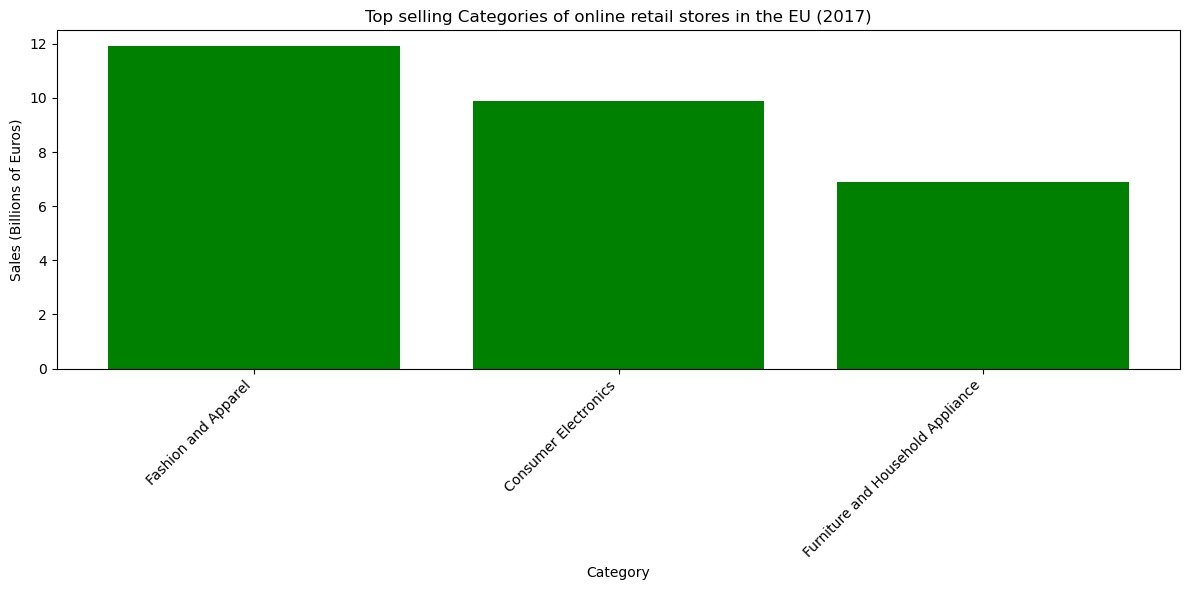

In [71]:

# Creating the bar plot
plt.figure(figsize=(12, 6))
plt.bar(df['Category'], df['Sales (Billions of Euros)'], color='green')
plt.xlabel('Category')
plt.ylabel('Sales (Billions of Euros)')
plt.title('Top selling Categories of online retail stores in the EU (2017)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()